# PCA Analysis - As a time series

We have seen that PCA analysis yields some insight but I have some further questions.

**Time series visualise**

Can we use the PCA analysis to visualise *changing* patterns in the behaviour.

In [1]:
import datetime
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from IPython.core.display import Javascript
from IPython.display import display
from IPython.display import HTML

from PedestrianDataImporter import getHourlyCounts
from Imputation import imputeMissing
from DataFrameManipulations import countsLongToWideHourly

## Data importing and some manipulations

Lets first import the Melbourne data and cut out a time window in 2018 and 2019 to deal with

In [2]:
df_counts,df_locations = getHourlyCounts['Melbourne']()
df_counts = imputeMissing(df_counts)

start_date = datetime.datetime(2018,1,1)
end_date   = datetime.datetime(2020,1,1)
cut = (df_counts['DateTime'] >  start_date) & (df_counts['DateTime'] < end_date ) 
df_cut = df_counts.loc[cut]
df1 = df_cut[['DateTime','LocationName','HourlyCount']]
df1 = df1.dropna(axis='columns',how='any')

Loading Melbourne_stored.pkl
Todo: Imputation


In [3]:
df_wide = countsLongToWideHourly(df1)
df_wide = df_wide.dropna(axis='columns',how='any')
sites_complete = df_wide.columns.tolist()
#sites_complete

We want vectors that represent a days worth of counts or a weeks worth of counts.
While we at it lets also take just weekdays and weekends, we have seen that these have different behaviours

In [4]:
df1['Day']  = df1['DateTime'].dt.dayofweek  # 0: Monday, 1: Tuesday, ..., 6: Sunday
df1['Hour'] = df1['DateTime'].dt.hour
df1['Week'] = df1['DateTime'].dt.isocalendar().week
df1['Year'] = df1['DateTime'].dt.year
df1['Date'] = df1['DateTime'].dt.date

df1['Day_Hour'] = df1['Day'] * 24 + df1['Hour']
df1['Year_Week'] = df1['Year'].astype(str) + "_" + df1['Week'].astype(str).str.zfill(2)  # zfill ensures week 1 is "01", week 2 is "02", etc.

weekdays = df1['Day'] < 5
weekends = df1['Day'] >= 5

df_days = df1.pivot_table(index=['LocationName', 'Date'],
    columns='Hour', values='HourlyCount', aggfunc='sum').reset_index()

df_weekdays = df1.loc[weekdays].pivot_table(index=['LocationName', 'Date'],
    columns='Hour', values='HourlyCount', aggfunc='sum').reset_index()

df_weekends = df1.loc[weekends].pivot_table(index=['LocationName', 'Date'],
    columns='Hour', values='HourlyCount', aggfunc='sum').reset_index()

df_weeks = df1.pivot_table(index=['LocationName', 'Year_Week'], 
    columns='Day_Hour', values='HourlyCount', aggfunc='sum').reset_index()

#Keep the weekly data format consistent with the others
def year_week_to_date(year_week):
    year, week = map(int, year_week.split('_'))
    return pd.to_datetime(f'{year} {week} 1', format='%Y %U %w')

df_weeks['Date'] = df_weeks['Year_Week'].apply(year_week_to_date)
df_weeks = df_weeks.drop(columns='Year_Week')

Now we have datatables with the aggregated days and weeks, we want some numpy arrays.
We will also throw out any rows with missing data. This isn't perfect but it will do for now.

In [5]:
hoursdays_columns = list(range(24))  # Assuming hours are from 0 to 23 after the pivot
hoursweeks_columns = list(range(7*24))  # Assuming hours are from 0 to 23 after the pivot

def aggregatedDFtoArray(df, columns):
    data = df[columns]
    arr = data.values
    mask = ~np.isnan(arr).any(axis=1)  # Create a mask for rows without NaN values
    arr = arr[mask]  # Filter out rows with NaN values in arr
    location_names = df['LocationName'].values[mask]  # Apply the same mask to the location names
    dates = df['Date'].values[mask]
    return arr, location_names,dates

day_array,day_labels,day_dates = aggregatedDFtoArray(df_days ,hoursdays_columns)
weekday_array,weekday_labels,_ = aggregatedDFtoArray(df_weekdays,hoursdays_columns)
weekend_array,weekend_labels,_ = aggregatedDFtoArray(df_weekends,hoursdays_columns)
week_array,week_labels,week_dates       = aggregatedDFtoArray(df_weeks,hoursweeks_columns)

## Time series inspection

In [6]:
def get_pca_from_pipeline(pipeline):
    for step in pipeline.steps:
        if isinstance(step[1], PCA):
            return step[1]
    return None
    
arr = day_array
labels = day_labels
dates =  day_dates
pipeline1 = Pipeline([
    ('pca', PCA())  
])

fitted = pipeline1.fit_transform(arr)
pca = get_pca_from_pipeline(pipeline1)
comps = pca.components_

In [7]:
df_pcadays = pd.DataFrame(fitted[:, :3], columns=[f'Component_{i+1}' for i in range(3)])
df_pcadays['Location'] = labels
df_pcadays['Date'] = dates
df_pcadays = df_pcadays.melt(id_vars=['Date', 'Location'], var_name='Component', value_name='Value')
df_pcadays = df_pcadays[df_pcadays['Location'].isin(sites_complete)]

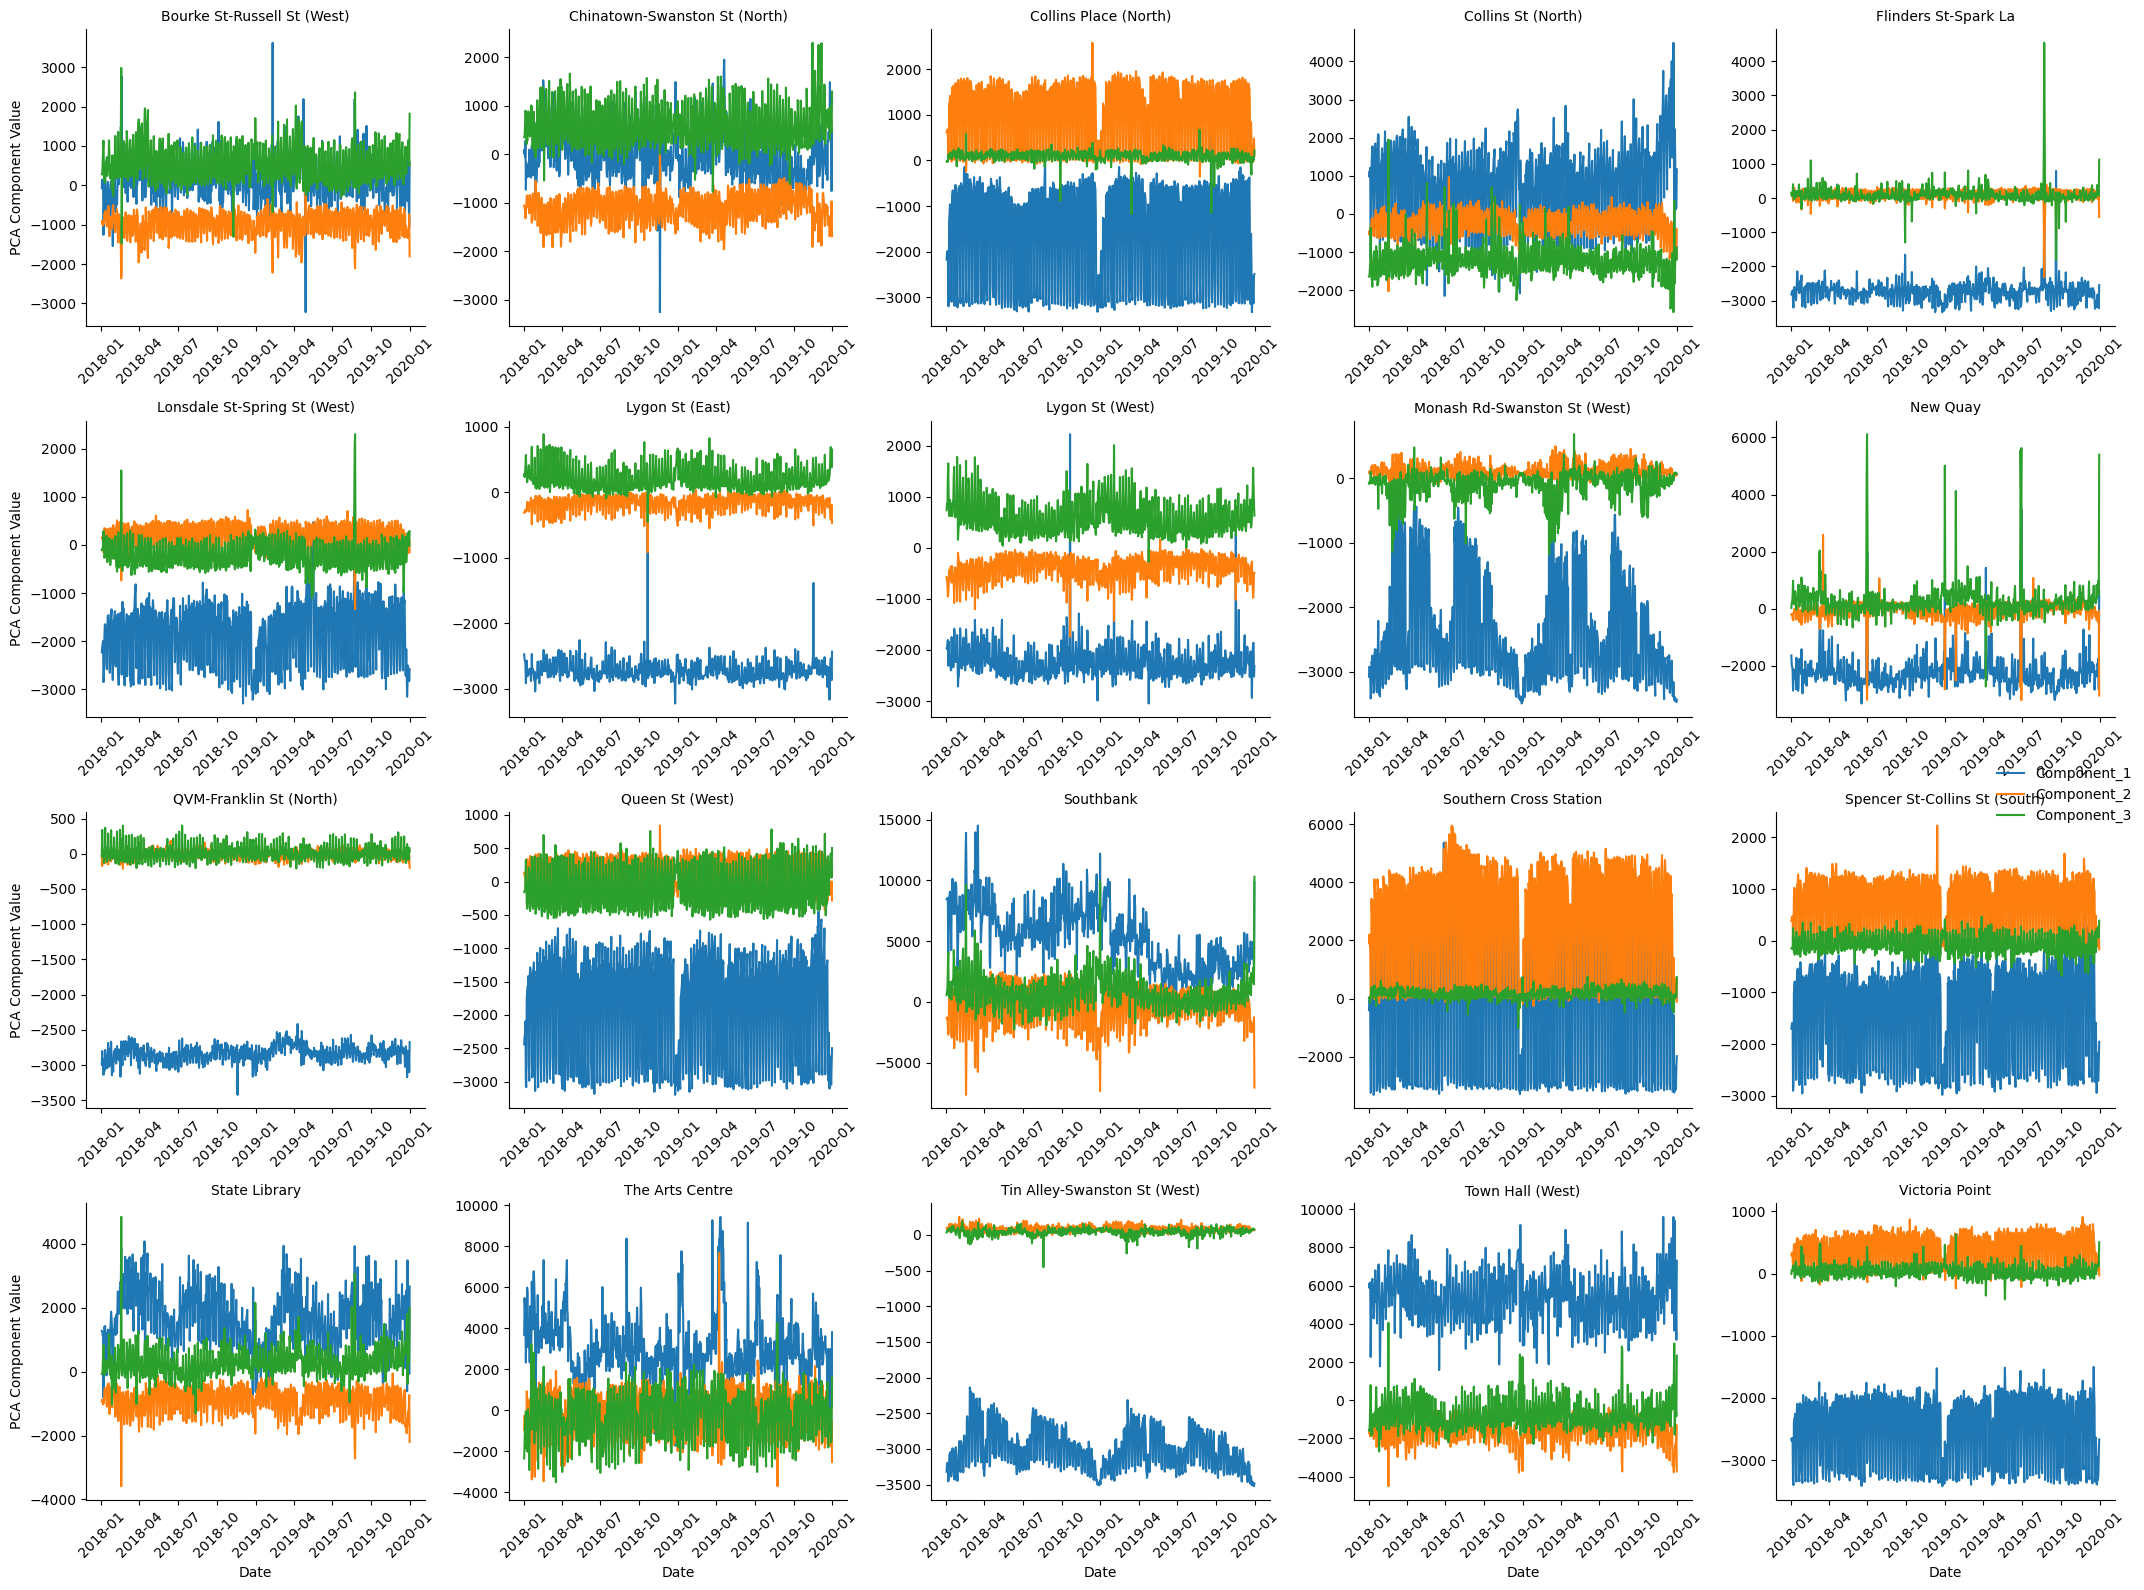

In [8]:
#sns.set(rc={'figure.figsize':(10,5)})

g = sns.FacetGrid(df_pcadays, col="Location", col_wrap=5, height=4, sharey=False, sharex=False)
g.map_dataframe(sns.lineplot, x='Date', y='Value', hue='Component')
g.add_legend()
g.set_axis_labels("Date", "PCA Component Value")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
#plt.show()

In [9]:
def get_pca_from_pipeline(pipeline):
    for step in pipeline.steps:
        if isinstance(step[1], PCA):
            return step[1]
    return None
    
arr = week_array
labels = week_labels
dates =  week_dates
pipeline1 = Pipeline([
    ('pca', PCA())  
])

fitted = pipeline1.fit_transform(arr)
pca = get_pca_from_pipeline(pipeline1)
comps = pca.components_

In [10]:
df_pcaweeks = pd.DataFrame(fitted[:, :3], columns=[f'Component_{i+1}' for i in range(3)])
df_pcaweeks['Location'] = labels
df_pcaweeks['Date'] = dates
df_pcaweeks = df_pcaweeks.melt(id_vars=['Date', 'Location'], var_name='Component', value_name='Value')
df_pcaweeks = df_pcaweeks[df_pcaweeks['Location'].isin(sites_complete)]

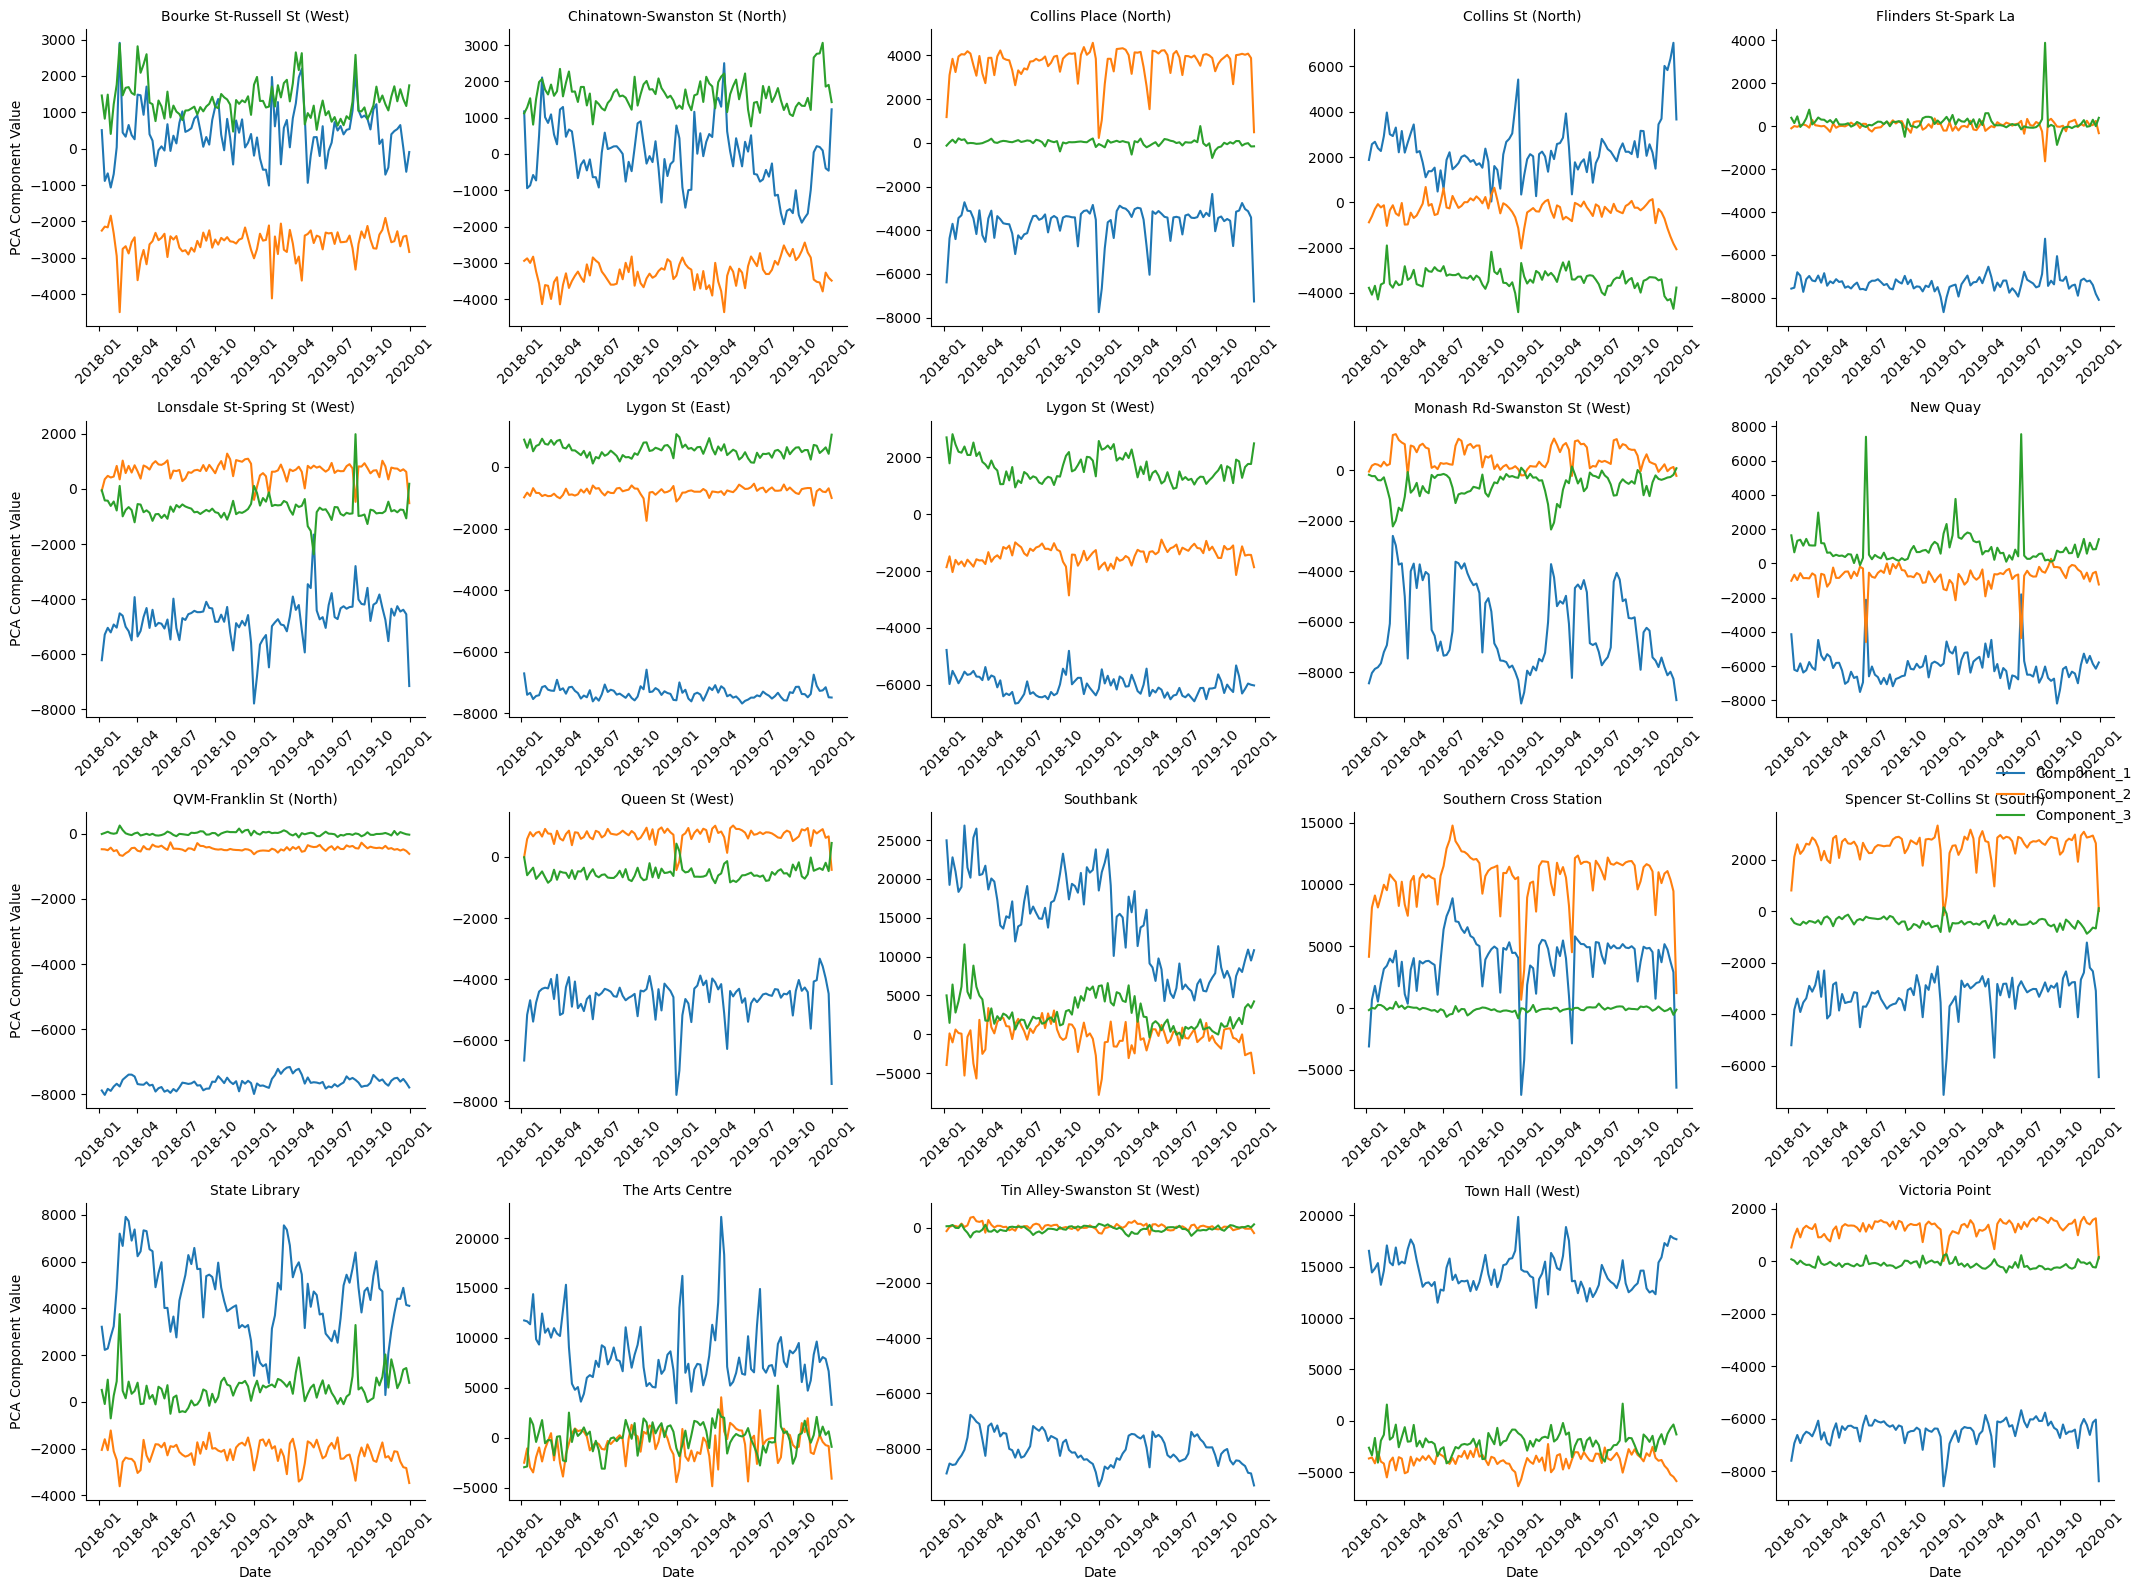

In [11]:
g = sns.FacetGrid(df_pcaweeks, col="Location", col_wrap=5, height=4, sharey=False, sharex=False)
g.map_dataframe(sns.lineplot, x='Date', y='Value', hue='Component')
g.add_legend()
g.set_axis_labels("Date", "PCA Component Value")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

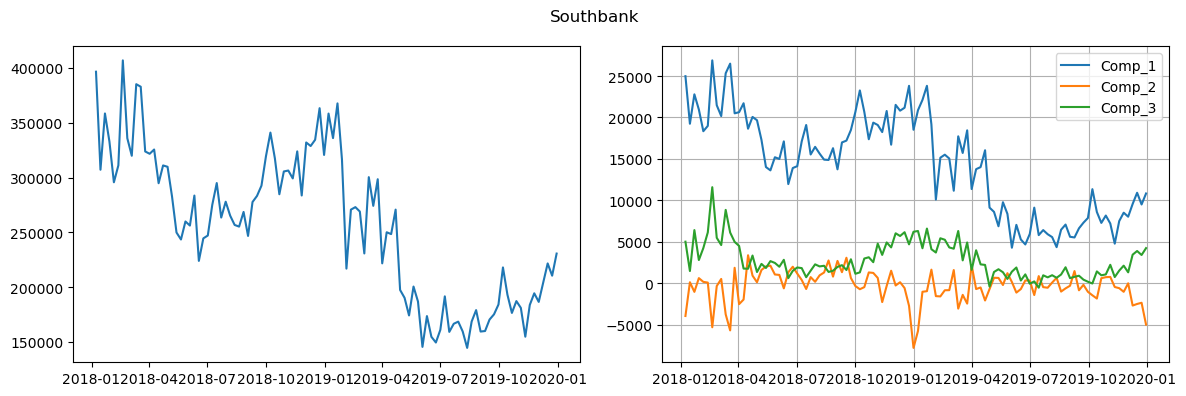

In [12]:
np.unique(labels)
loc = 'Southbank'

def plotSideBySide(loc):
    fig,axs = plt.subplots(1,2,figsize=(12,4))
    axs[0].plot( week_dates[labels==loc],week_array[labels==loc,:].sum(axis=1) )
    for i in range(1,4):
        d = df_pcaweeks.loc[(df_pcaweeks['Location'] == loc) & (df_pcaweeks['Component'] == f'Component_{i}')]
        axs[1].plot( d['Date'].values,
                     d['Value'].values,label=f'Comp_{i}' )
    
    axs[1].legend()
    axs[1].grid()
    plt.suptitle(loc)
    plt.tight_layout()

#for loc in np.unique(labels):
#    plotSideBySide(loc)
#week_dates.shape
plotSideBySide(loc)

Repeat that last plot for GISRUK:

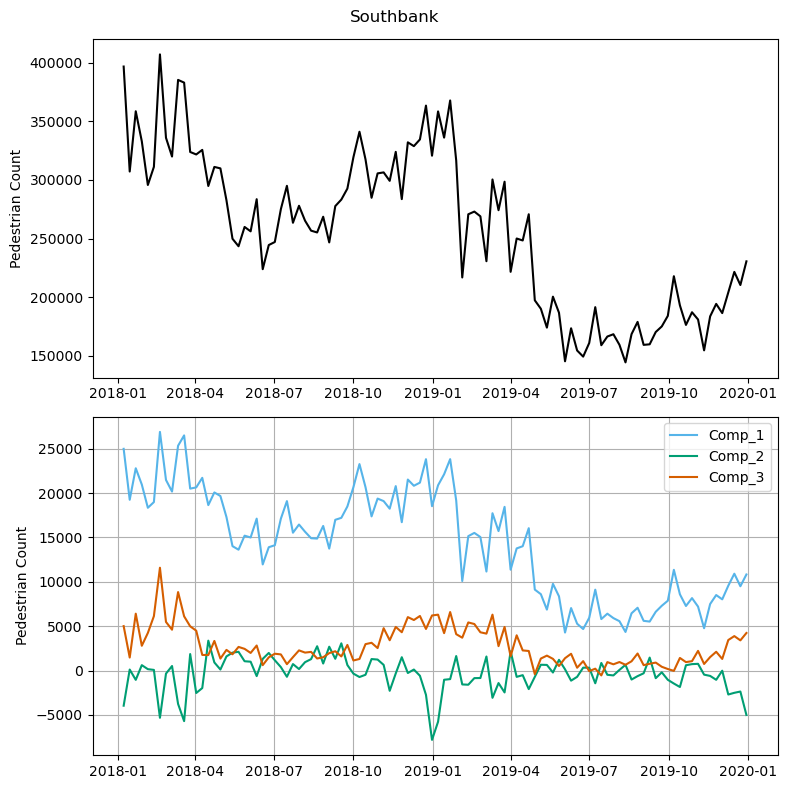

In [13]:
loc = 'Southbank'
line_colors = ['#56B4E9', '#009E73', '#D55E00']

fig,axs = plt.subplots(2,1,figsize=(8,8))
axs[0].plot(week_dates[labels==loc],week_array[labels==loc,:].sum(axis=1), color="black" )
axs[0].set_ylabel("Pedestrian Count")
for i in range(1,4):
    d = df_pcaweeks.loc[(df_pcaweeks['Location'] == loc) & (df_pcaweeks['Component'] == f'Component_{i}')]
    axs[1].plot( d['Date'].values,
                 d['Value'].values,label=f'Comp_{i}',
               color = line_colors[i-1])
    axs[1].set_ylabel("Pedestrian Count")

axs[1].legend()
axs[1].grid()
plt.suptitle(loc)
plt.tight_layout()

fig.savefig("Plots/PCA/Weekly_Comps_for_GIRSUK.pdf", format='pdf', bbox_inches='tight')

## Changes over time

Can we see changes over time using the PCA?

In [14]:
cut = (df_counts['DateTime'] > datetime.datetime(2018,1,1))
df_post = df_counts.loc[cut]
df_post = df_post[['DateTime','LocationName','HourlyCount']]

In [15]:
df_post['Day']  = df_post['DateTime'].dt.dayofweek  # 0: Monday, 1: Tuesday, ..., 6: Sunday
df_post['Hour'] = df_post['DateTime'].dt.hour
df_post['Week'] = df_post['DateTime'].dt.isocalendar().week
df_post['Year'] = df_post['DateTime'].dt.year

df_post['Day_Hour'] = df_post['Day'] * 24 + df_post['Hour']
df_post['Year_Week'] = df_post['Year'].astype(str) + "_" + df_post['Week'].astype(str).str.zfill(2)  # zfill ensures week 1 is "01", week 2 is "02", etc.

df_post = df_post.pivot_table(index=['LocationName', 'Year_Week'], 
    columns='Day_Hour', values='HourlyCount', aggfunc='sum').reset_index()

#Keep the weekly data format consistent with the others
def year_week_to_date(year_week):
    year, week = map(int, year_week.split('_'))
    return pd.to_datetime(f'{year} {week} 1', format='%Y %U %w')

df_post['Date'] = df_post['Year_Week'].apply(year_week_to_date)
df_post = df_post.drop(columns='Year_Week')

post_array,post_labels,post_dates       = aggregatedDFtoArray(df_post,hoursweeks_columns)

In [16]:
def get_pca_from_pipeline(pipeline):
    for step in pipeline.steps:
        if isinstance(step[1], PCA):
            return step[1]
    return None
    
arr = week_array
labels = week_labels
dates =  week_dates
pipeline1 = Pipeline([
    ('pca', PCA())  
])

fitted = pipeline1.fit_transform(arr)
pca = get_pca_from_pipeline(pipeline1)
comps = pca.components_

In [17]:
fitted = pipeline1.transform(post_array)

In [18]:
df_pcapost = pd.DataFrame(fitted[:, :3], columns=[f'Component_{i+1}' for i in range(3)])
df_pcapost['Location'] = post_labels
df_pcapost['Date'] = post_dates
df_pcapost = df_pcapost.melt(id_vars=['Date', 'Location'], var_name='Component', value_name='Value')
df_pcapost = df_pcapost[df_pcapost['Location'].isin(sites_complete)]

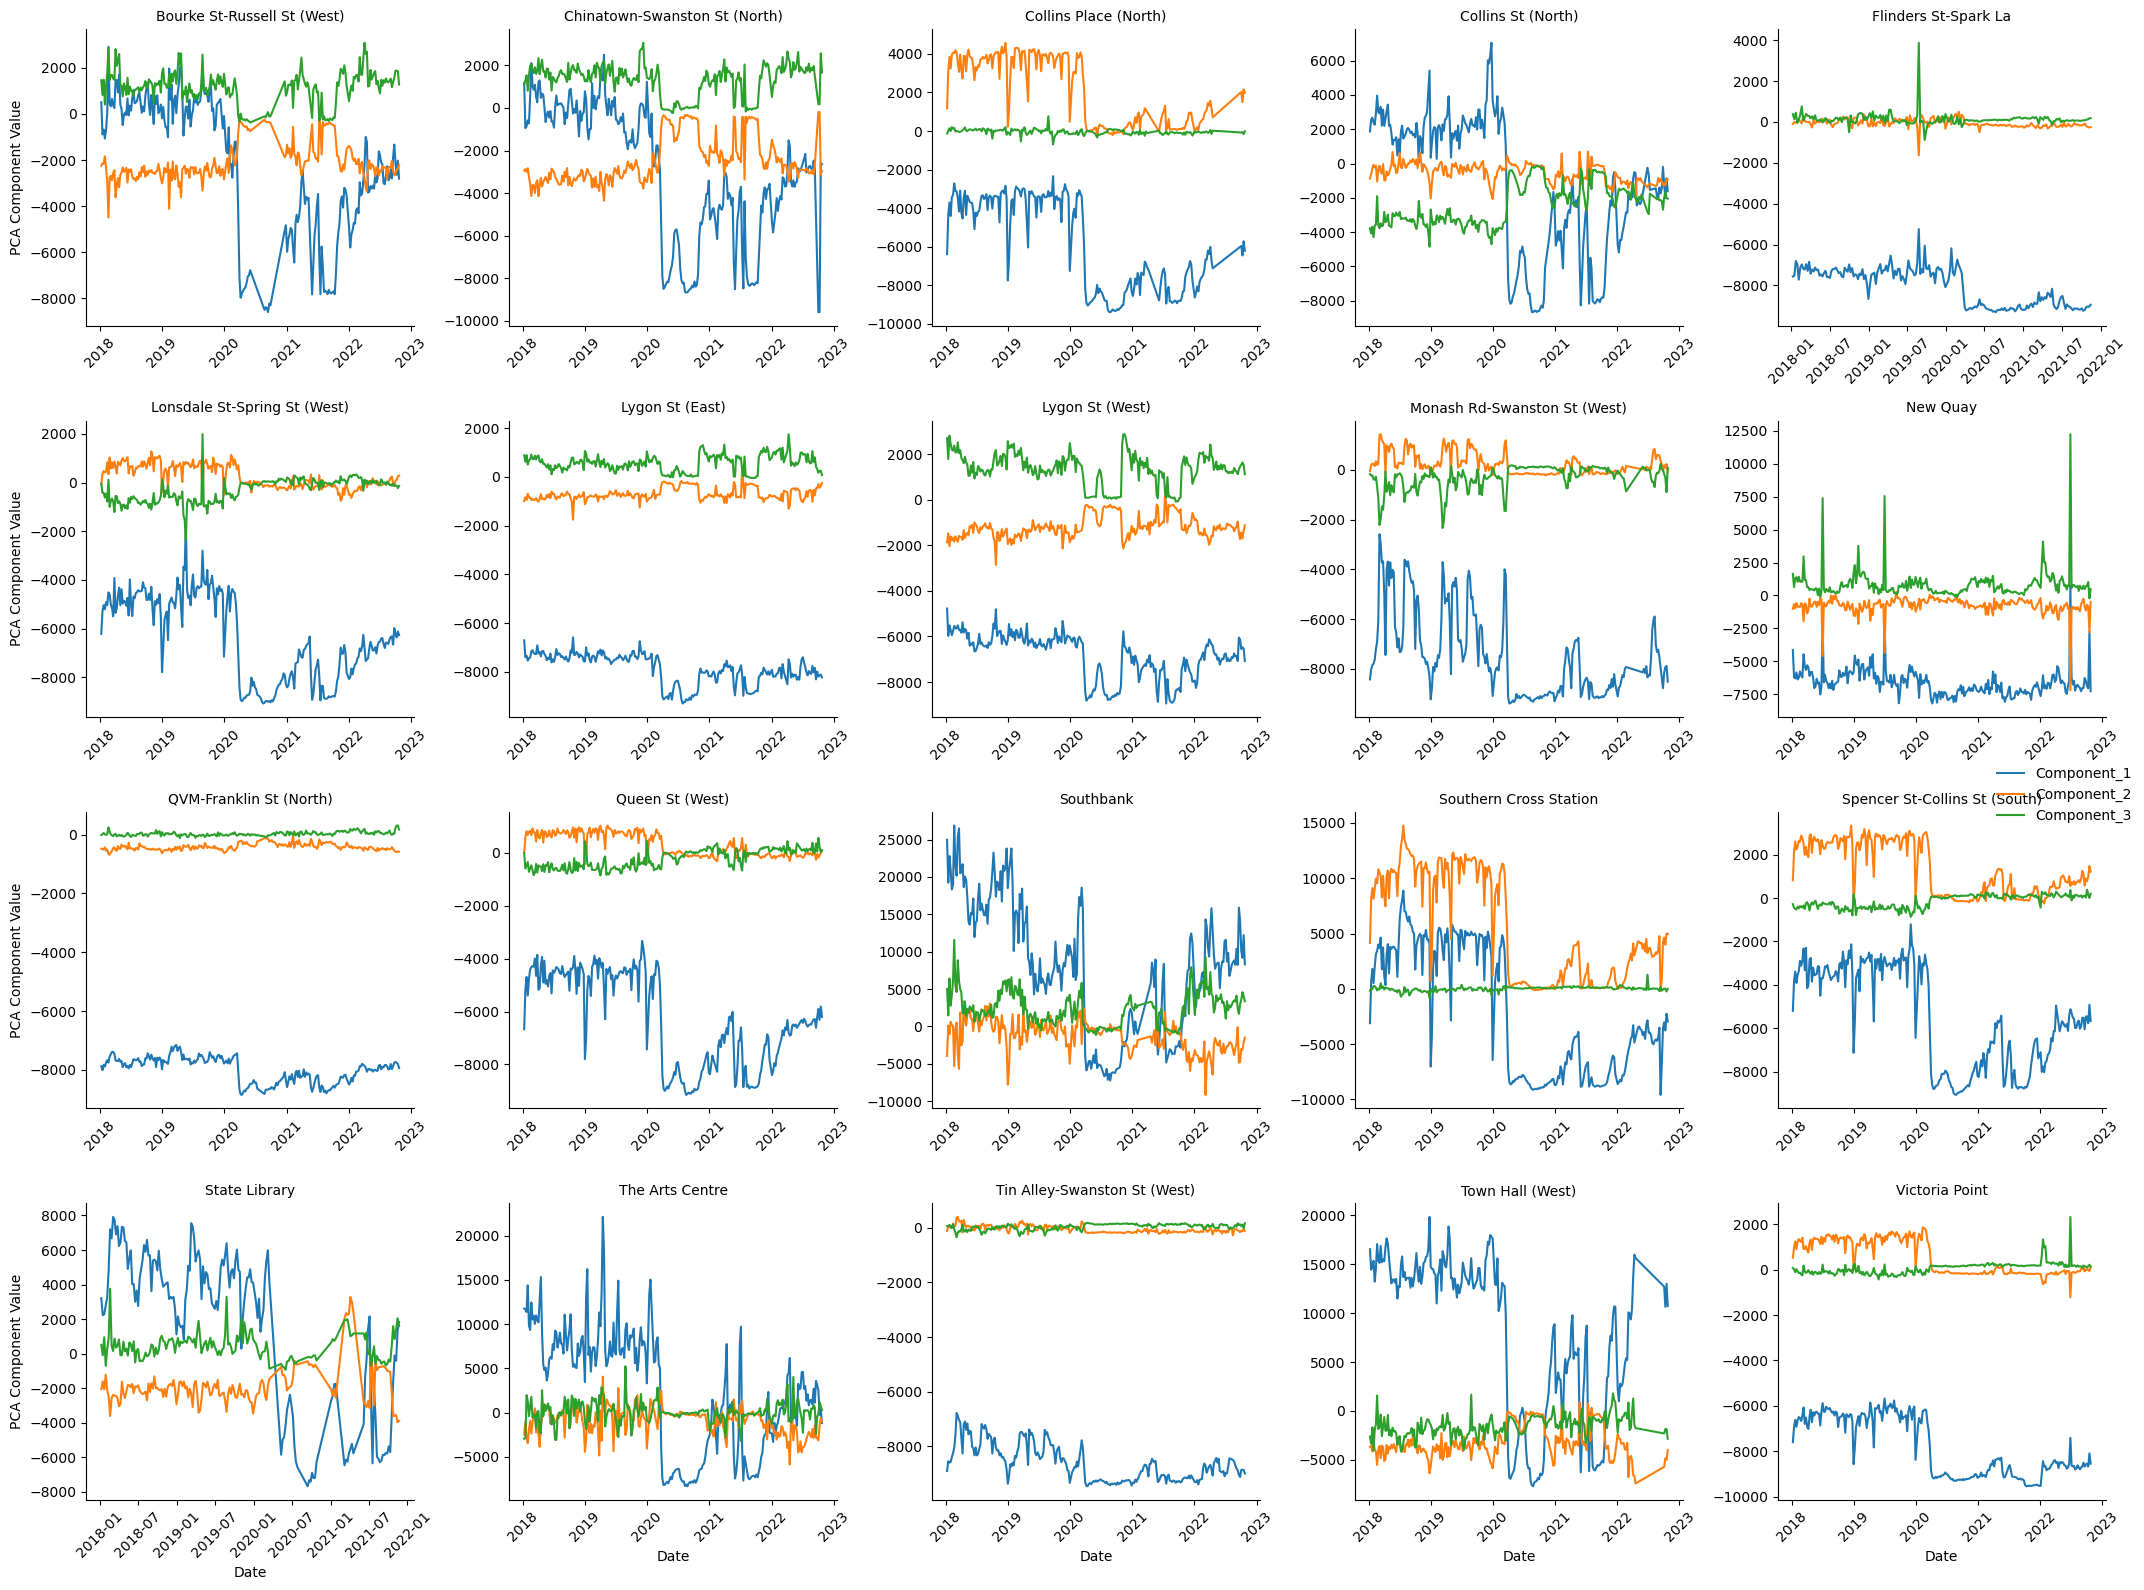

In [19]:
g = sns.FacetGrid(df_pcapost, col="Location", col_wrap=5, height=4, sharey=False, sharex=False)
g.map_dataframe(sns.lineplot, x='Date', y='Value', hue='Component')
g.add_legend()
g.set_axis_labels("Date", "PCA Component Value")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()